# Semi-Supervised Learning (SSL)


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels

In [2]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = None

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = None
params['c_u'] = None

In [3]:
def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl)-1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    # ...

    l_idx = np.arange(len(Y))[Y!=0]
    u_idx = np.arange(len(Y))[Y==0]
    y = np.zeros((num_samples, num_classes))
    y[l_idx, Y[l_idx].astype(int)-1] = 1
    
    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        # f_l = None
        # f_u = None
        # f = None
    
        # # ...

        f_l = y[l_idx]

        L_ul = L[u_idx,:][:,l_idx]
        L_uu = L[u_idx,:][:,u_idx]
        f_u = np.linalg.solve(L_uu,-L_ul@f_l)

        f = np.zeros(y.shape)
        f[l_idx] = f_l
        f[u_idx] = f_u

    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        # f = None
        # C = None
        # # ...

        C = np.zeros(num_samples)
        C[l_idx] = params['c_l']
        C[u_idx] = params['c_u']
        C = np.diag(C)
        f = np.linalg.solve(np.linalg.pinv(C)@L + np.eye(num_samples), y)

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = np.argmax(f, axis=1) + 1
    return labels, f


In [4]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', plot=True, seed=None, **params):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    
    # L = ...

    L = build_laplacian_regularized(
                X,
                params['laplacian_regularization'],
                var=params['var'],
                eps=params['eps'],
                k=params['k'],
                laplacian_normalization=params['laplacian_normalization'],
    )

    labels, f = compute_hfs(L, Y_masked, soft, **params)

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

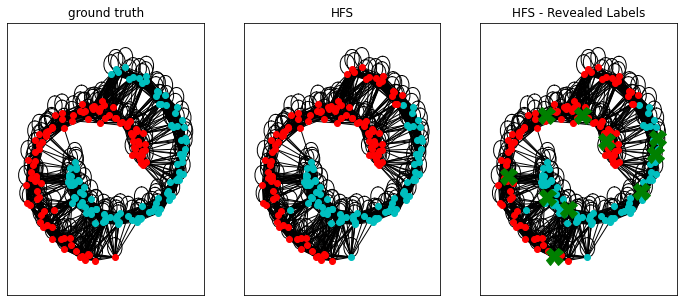

Soft=False, Accuracy=0.91


In [5]:
params['k'] = 23
params['laplacian_normalization'] = 'rw'

seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=False, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

In [6]:
np.random.seed(40)
for ii in range(10):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, 
                                                     dataset='data_2moons_hfs_large.mat',
                                                     plot=False, seed=None, **params)
    
# mask_labels?  # check parameters

Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0


When $l$ is small, we might have only one label in the dataset so in this case the output is always the same label. But thanks to assert len(np.unique(Y_masked)) > 2, "only one class in training data!", the function raises an error when this happens.

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

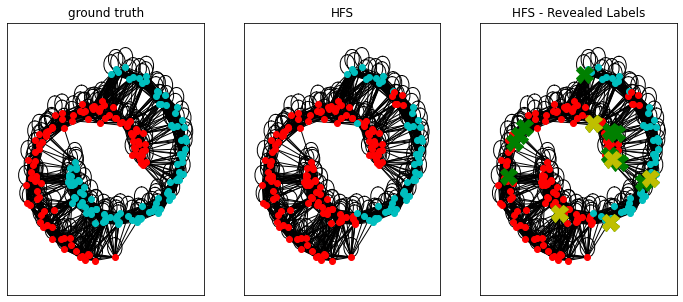

Soft=False, Accuracy=0.765


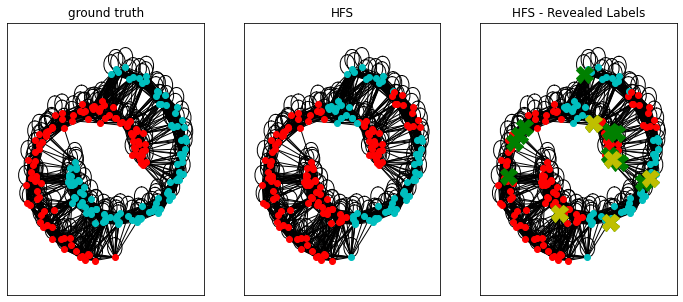

Soft=True, Accuracy=0.68


In [7]:
# Comparing
seed = 10  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'


params['laplacian_regularization'] = 0
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

params['laplacian_regularization'] = 1
params['c_l'] = 0.95
params['c_u'] = 0.1
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

By averaging on some random seeds we obtain better results with Soft.

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

2.1. If we have more than 2 classes, we consider $y \in [N]$ and the output of HFS is a probability vector of size $N$. Then we select the highest probability in this vector.

2.2 For the small dataset, accuracy of 0.83
And for the augmented dataset, accuracy of 0.65

2.3. The accuracy changes when using the augmented dataset. In fact, it is always worse. So here augmenting the data does not lead to a better accuracy. We can see in the confusion matrices that there is more uncertainty when we use the augmented dataset. This is because we have, in proportion, less data to do the classification.

In [8]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [9]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 0.1
params_face_rec['var'] = 100.0
params_face_rec['eps'] = 0
params_face_rec['k'] = 15
params_face_rec['laplacian_normalization'] = 'rw'
params_face_rec['c_l'] = 0.95
params_face_rec['c_u'] = 0.05

In [10]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float64)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

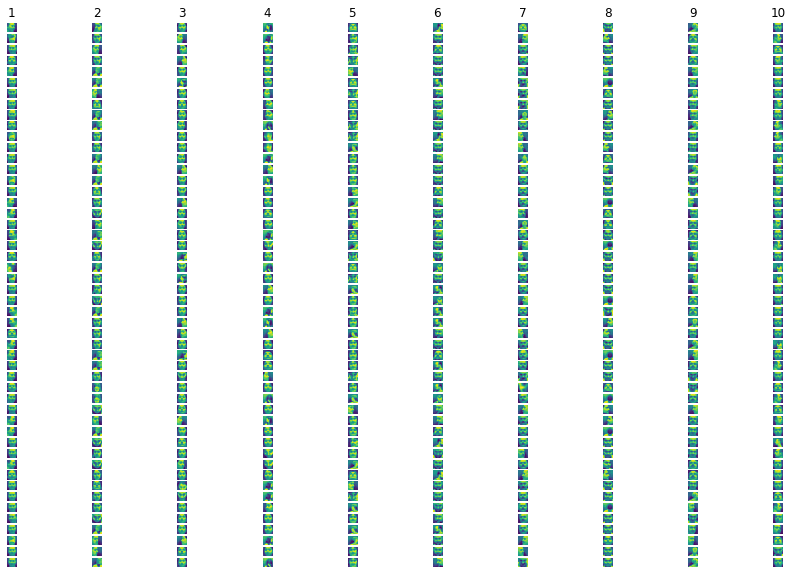

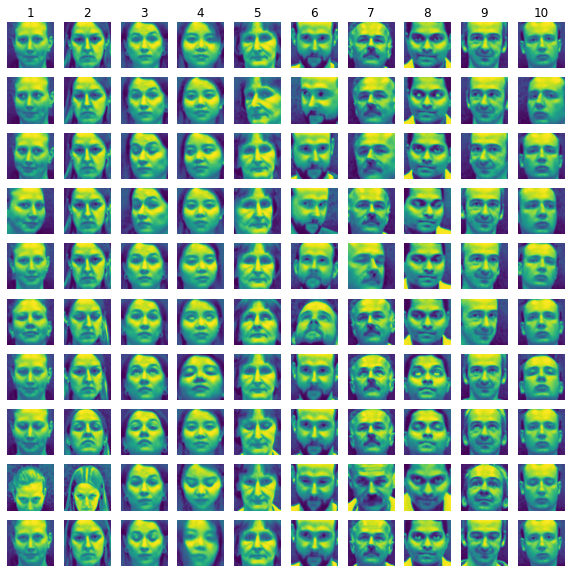

(100, 9216)
[[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.]
 [ 1.  2.  0.  4.  0.  0.  7.  0.  0.  0.]
 [ 1.  0.  3.  0.  0.  0.  0.  0.  9.  0.]
 [ 1.  0.  3.  0.  0.  6.  0.  0.  9. 10.]
 [ 0.  0.  0.  4.  5.  6.  0.  8.  0.  0.]
 [ 0.  0.  0.  4.  5.  0.  0.  0.  0.  0.]
 [ 0.  2.  3.  0.  0.  0.  0.  0.  9. 10.]
 [ 0.  0.  0.  0.  5.  6.  7.  0.  0. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  8.  9. 10.]
 [ 0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]]


In [11]:
# 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

# # 50 images per person
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
plot_image_data_augmented(images_a)

# Uncomment below if you want to visualize the images
plot_image_data(images)
print(images.shape)
print(masked_labels.reshape(-1, 10))

In [12]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

Accuracy =  0.83
[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.  1.  2.  0.  4.  0.  0.  7.  0.
  0.  0.  1.  0.  3.  0.  0.  0.  0.  0.  9.  0.  1.  0.  3.  0.  0.  6.
  0.  0.  9. 10.  0.  0.  0.  4.  5.  6.  0.  8.  0.  0.  0.  0.  0.  4.
  5.  0.  0.  0.  0.  0.  0.  2.  3.  0.  0.  0.  0.  0.  9. 10.  0.  0.
  0.  0.  5.  6.  7.  0.  0. 10.  0.  0.  0.  0.  5.  0.  0.  8.  9. 10.
  0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  3  9  7  8  9  9  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6 10  8
  1  4 10  2  4  4  5  4  7  8  1 10  1  2  3 10  5  6  7  3  9 10  1  2
 10  4  5  6  7  4  9 10  4  4  3  4  5  6  8  8  9 10  1  2  3  4  5  6
  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8
  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2
  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9

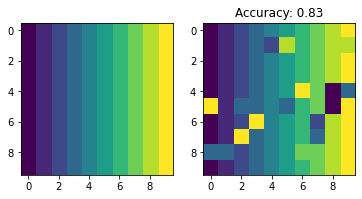

In [13]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

print(masked_labels)
print(predicted_labels)
print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

In [14]:
L_a = build_laplacian_regularized(
    images_a,
    params_face_rec["laplacian_regularization"],
    params_face_rec["var"],
    params_face_rec["eps"],
    params_face_rec["k"],
    params_face_rec["laplacian_normalization"],
)

Accuracy on augmented dataset=  0.646
[ 0.  0.  0.  0.  0.  6.  7.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.
  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  7.  8.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.
  0.  0.  1.  2.  3.  0.  0.  0.  0.  0.  9.  0.  0.  2.  0.  0.  5.  6.
  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.
  0.  0.  0.  0.  7.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.
  0.  0.  0.  2.  0.  0.  5.  6.  7.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. 

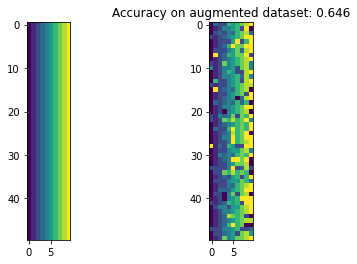

In [15]:
predicted_labels_a, f_a = compute_hfs(L_a, masked_labels_a, soft=True, **params_face_rec)
accuracy_a = np.equal(predicted_labels_a, labels_a).mean()

print("Accuracy on augmented dataset= ", accuracy_a)

print(masked_labels_a)
print(predicted_labels_a)
print(labels_a)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_a.reshape((-1, 10)))
plt.title("Accuracy on augmented dataset: {}".format(accuracy_a))
plt.show()

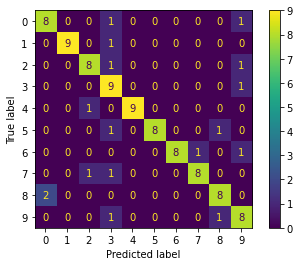

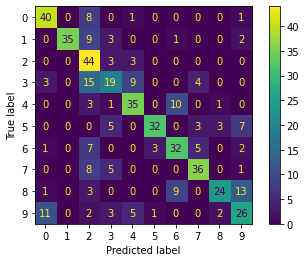

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(labels, predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

cm_a = confusion_matrix(labels_a, predicted_labels_a)
cm_display_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=np.arange(10))

cm_display.plot()

cm_display_a.plot()

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`
    
### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.


3.1. (Normally there is an image here)

3.2. We can keep only the predictions with high probability (above a certain threshold), i took 80%

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition

In [18]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 1.0
params_online_ssl['var'] = 10.0
params_online_ssl['eps'] = 0.0
params_online_ssl['k'] = 15
params_online_ssl['laplacian_normalization'] = 'rw'
params_online_ssl['c_l'] = 0.95
params_online_ssl['c_u'] = 0.05

In [19]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50, update=False):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None

        self.update = update
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])


    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
            # c_rep, c_add = None, None

            # # ...

            d = self.centroids_distances.copy()
            d[~self.taboo, :] = np.inf
            c_1 = d.min(axis=1).argmin() 
            c_2 = d[c_1, :].argmin()

            if self.taboo[c_2]:
                c_rep, c_add = c_2, c_1
            elif self.V[c_1] > self.V[c_2]: 
                c_rep, c_add = c_1, c_2
            else:
                c_rep, c_add = c_2, c_1

            """
            Update data structures: self.centroids and self.V
            """
            # ...

            if not self.update:
                self.V[c_rep] = self.V[c_add] + self.V[c_rep]
                self.centroids[c_add, :] = face
                self.V[c_add] = 1

            else:
                if not self.taboo[c_rep] and self.V[c_rep] > 4: # face seen enough times but not labelled -> label it
                    self.taboo[c_rep] = True
                    self.taboo[c_add] = True
                    new_label = np.max(self.Y) + 1
                    self.Y[c_rep] = new_label
                    self.Y[c_add] = new_label
                    self.label_names += [f"Person: {new_label}"]
                    self.n_labeled_faces += 1
                    self.n_labels += 1

                if self.taboo[c_rep] and (self.Y == self.Y[c_rep]).sum() < 4: # face labelled but not seen a lot
                    self.Y = np.append(self.Y, self.Y[c_rep])
                    self.taboo = np.append(self.taboo, True)
                    self.centroids = np.concatenate([self.centroids, np.array([self.centroids[c_add]])], axis=0)
                    self.V = np.append(self.V, self.V[c_add])

                    # update
                    distance_with_new_centroid = distance.cdist(np.array([self.centroids[-1]]),self.centroids,)[0]
                    self.centroids_distances = np.concatenate([self.centroids_distances,np.array([distance_with_new_centroid[:-1]]),],axis=0,)
                    self.centroids_distances = np.concatenate([self.centroids_distances,np.array([distance_with_new_centroid]).T,],axis=1,)
                    self.n_labeled_faces += 1
                    self.max_num_centroids += 1

                else:
                    self.V[c_rep] += self.V[c_add]

                self.centroids[c_add, :] = face
                self.V[c_add] = 1

            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        
        # W = ...
        # L = ...
        # Q = ...   # regularized Laplacian

        W = build_similarity_graph(
            self.centroids,
            params_face_rec['var'],
            params_face_rec['eps'],
            params_face_rec['k'],
        )
        L = build_laplacian(V@W@ V, params_face_rec['laplacian_normalization'])
        Q = L + params_face_rec['laplacian_regularization'] * np.eye(W.shape[0])

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))
        
        # handle unknown faces
        # ...
            
        label_scores = [score for score in label_scores if score[1] > 0.8]
        if len(label_scores) == 0:
            label_scores = [('Unknown', 1)]

        return label_scores
      


In [20]:
# create_user_profile('bob')         # choose your names here :)
# create_user_profile('alice')
online_face_recognition(['bob', 'alice'], IncrementalKCenters, n_pictures=15)

Profile found with 11 images.
Profile found with 7 images.


### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification

> If there is a unknown face that appears frequently (more than times for example) then we add it to the dataset. Otherwise we proceed as before (see the code above).
    
### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once